# 使用决策树和随机森林预测员工离职率

我们的任务是帮助人事部门理解员工为何离职, 预测一个员工离职的可能性.
数据来源: https://www.kaggle.com/ludobenistant/hr-analytics

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# 数据读取

In [2]:
# 读入数据到Pandas Dataframe "df"
df = pd.read_excel('player1.xlsx')

# 数据预处理

In [3]:
# 检测是否有缺失数据
df.isnull().sum()

match_id              0
player1               0
server                0
p1_winner             0
p1_unf_err            0
p1_net_pt_won         0
p1_break_pt_missed    0
p1_points_won         0
set_no                0
F                     0
dtype: int64

In [4]:
df['p1_points_won_diff'] = df['p1_points_won'].diff()
df['server'] = df['server'].replace({1:1, 2: 0})
df=df.drop('match_id',axis=1)
df=df.drop('player1',axis=1)
df=df.drop('set_no',axis=1)
df=df.drop('F',axis=1)
df=df.drop('p1_points_won',axis=1)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1207 entries, 0 to 1206
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   server              1207 non-null   int64  
 1   p1_winner           1207 non-null   int64  
 2   p1_unf_err          1207 non-null   int64  
 3   p1_net_pt_won       1207 non-null   int64  
 4   p1_break_pt_missed  1207 non-null   int64  
 5   p1_points_won_diff  1206 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 56.7 KB


In [5]:
df['p1_points_won_diff'].value_counts()

 1.0      639
 0.0      563
-157.0      1
-121.0      1
-102.0      1
-91.0       1
Name: p1_points_won_diff, dtype: int64

In [7]:
df['p1_points_won_diff']=df['p1_points_won_diff'].fillna(0)
df.loc[df['p1_points_won_diff'] < 0, 'p1_points_won_diff'] = 0
df['p1_points_won_diff'].value_counts()

1.0    639
0.0    568
Name: p1_points_won_diff, dtype: int64

In [8]:
# 将预测标签‘是否离职’放在第一列
front = df['p1_points_won_diff']
df.drop(labels=['p1_points_won_diff'], axis=1, inplace = True)
df.insert(0, 'p1_points_won_diff', front)
df.head()

,p1_points_won_diff,server,p1_winner,p1_unf_err,p1_net_pt_won,p1_break_pt_missed
0,0.0,1,0,1,0,0
1,1.0,1,0,0,0,0
2,0.0,1,0,1,0,0
3,1.0,1,1,0,0,0
4,1.0,1,1,0,0,0


## 数据统计分析

In [9]:
# 共334个样本，每一个样本中包含5个特征
df.shape

(1207, 6)

In [10]:
# 特征数据类型. 
df.dtypes

p1_points_won_diff    float64
server                  int64
p1_winner               int64
p1_unf_err              int64
p1_net_pt_won           int64
p1_break_pt_missed      int64
dtype: object

In [11]:
# 概率统计
p1_points_won_diff_rate = df.p1_points_won_diff.value_counts() / len(df)
p1_points_won_diff_rate

1.0    0.529412
0.0    0.470588
Name: p1_points_won_diff, dtype: float64

In [12]:
# 显示统计数据
df.describe()

,p1_points_won_diff,server,p1_winner,p1_unf_err,p1_net_pt_won,p1_break_pt_missed
count,1207.000000,1207.000000,1207.000000,1207.000000,1207.000000,1207.000000
mean,0.529412,0.478873,0.169014,0.106048,0.090307,0.036454
std,0.499341,0.499761,0.374920,0.308027,0.286739,0.187495
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


##  相关性分析
***

- 什么特征的影响最大?
- 什么特征之间相关性最大?


,p1_points_won_diff,server,p1_winner,p1_unf_err,p1_net_pt_won,p1_break_pt_missed
p1_points_won_diff,1.000000,0.292399,0.425195,-0.365318,0.297054,-0.206306
server,0.292399,1.000000,0.187238,0.116909,0.207167,-0.186455
p1_winner,0.425195,0.187238,1.000000,-0.155331,0.235846,-0.087720
p1_unf_err,-0.365318,0.116909,-0.155331,1.000000,-0.108519,0.047866
p1_net_pt_won,0.297054,0.207167,0.235846,-0.108519,1.000000,-0.061284
p1_break_pt_missed,-0.206306,-0.186455,-0.087720,0.047866,-0.061284,1.000000


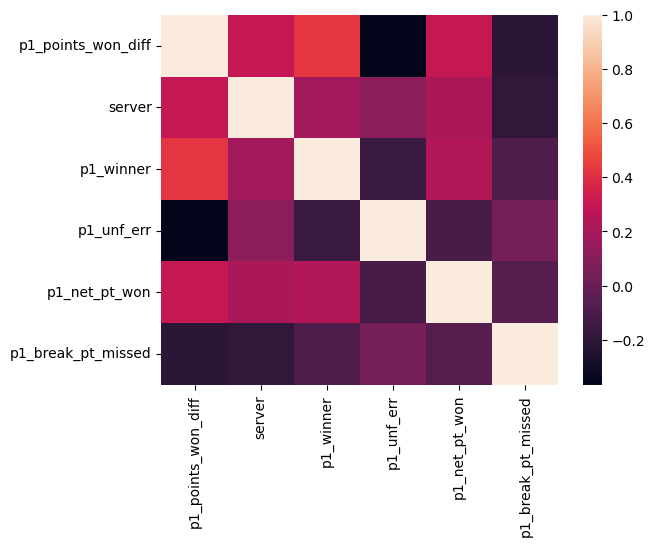

In [13]:
# 相关性矩阵

corr = df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

corr

In [16]:
# 比较离职和未离职员工的满意度
emp_population = df['server'][df['p1_points_won_diff'] == 0].mean()
emp_turnover_satisfaction = df[df['p1_points_won_diff']==1]['server'].mean()

print( 'not_server: ' + str(emp_population))
print( 'is_server: ' + str(emp_turnover_satisfaction) )

not_server: 0.323943661971831
is_server: 0.6165884194053208


## 进行 T-Test
***
进行一个 t-test, 看server明显不同


In [22]:
import scipy.stats as stats
# t-Test
stats.ttest_1samp(a = df[df['p1_points_won_diff']==1]['server'], # 离职员工的满意度样本
                  popmean = emp_population)  # 未离职员工的满意度均值

TtestResult(statistic=15.202702355644774, pvalue=9.03940279728512e-45, df=638)

T-Test 显示pvalue **(0)** 非常小, 所以他们之间是显著不同的

In [23]:
degree_freedom = len(df[df['p1_points_won_diff']==1])
# 临界值
LQ = stats.t.ppf(0.025,degree_freedom)  # 95%致信区间的左边界
RQ = stats.t.ppf(0.975,degree_freedom)  # 95%致信区间的右边界
print ('The t-分布 左边界: ' + str(LQ))
print ('The t-分布 右边界: ' + str(RQ))

The t-分布 左边界: -1.9636833813343266
The t-分布 右边界: 1.9636833813343262


[Text(0.5, 0, 'server'), Text(0, 0.5, 'p')]

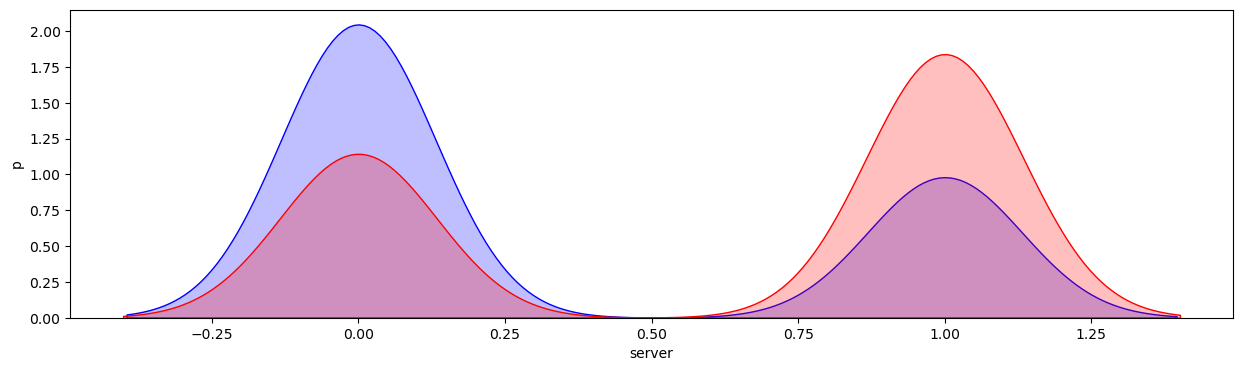

In [39]:
# 概率密度函数估计
fig = plt.figure(figsize=(15,4),)
ax=sns.kdeplot(df.loc[(df['p1_points_won_diff'] == 0),'server'] , color='b',shade=True,label='no countinue')
ax=sns.kdeplot(df.loc[(df['p1_points_won_diff'] == 1),'server'] , color='r',shade=True, label='countinue')
ax.set(xlabel='server', ylabel='p')


[Text(0.5, 0, 'p1_winner'), Text(0, 0.5, 'p')]

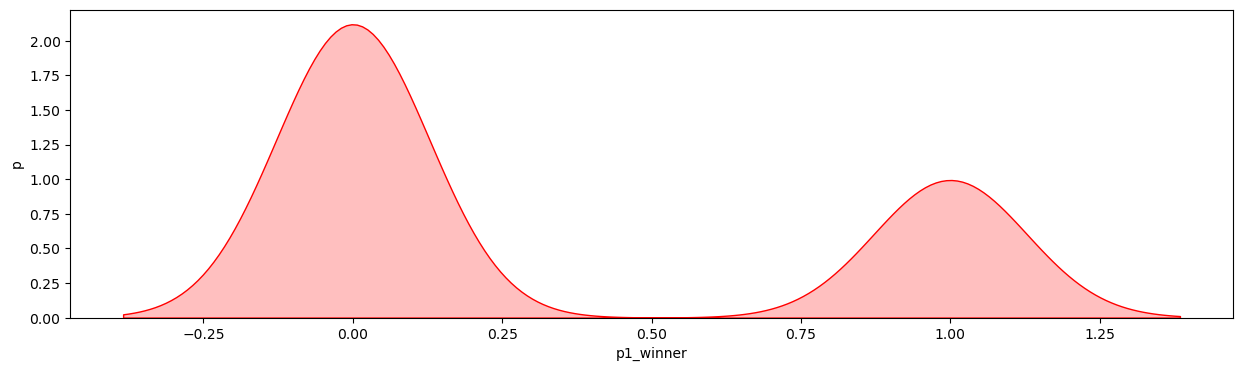

In [40]:
fig = plt.figure(figsize=(15,4),)
ax=sns.kdeplot(df.loc[(df['p1_points_won_diff'] == 0),'p1_winner'] , color='b',shade=True,label='no countinue')
ax=sns.kdeplot(df.loc[(df['p1_points_won_diff'] == 1),'p1_winner'] , color='r',shade=True, label='countinue')
ax.set(xlabel='p1_winner', ylabel='p')


[Text(0.5, 0, 'p1_unf_err'), Text(0, 0.5, 'p')]

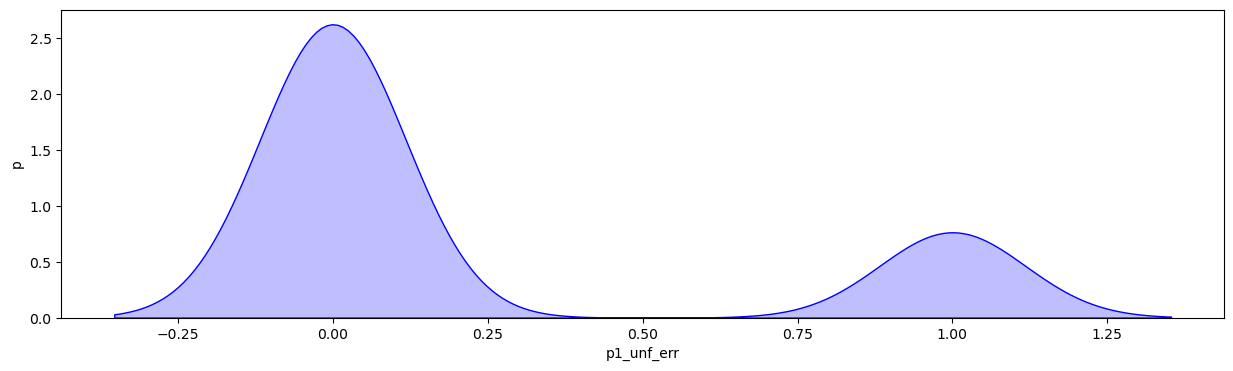

In [41]:
fig = plt.figure(figsize=(15,4),)
ax=sns.kdeplot(df.loc[(df['p1_points_won_diff'] == 0),'p1_unf_err'] , color='b',shade=True,label='no countinue')
ax=sns.kdeplot(df.loc[(df['p1_points_won_diff'] == 1),'p1_unf_err'] , color='r',shade=True, label='countinue')
ax.set(xlabel='p1_unf_err', ylabel='p')


In [24]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, confusion_matrix, precision_recall_curve

In [25]:
# 类型转换
df['p1_points_won_diff'] = df['p1_points_won_diff'].astype('int64')

# 产生X, y，即特征值与目标值
target_name = 'p1_points_won_diff'
X = df.drop('p1_points_won_diff', axis=1)
y = df[target_name]

# 将数据分为训练和测试数据集
# 注意参数 stratify = y 意味着在产生训练和测试数据中, 离职的员工的百分比等于原来总的数据中的离职的员工的百分比
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123)
# 显示前5行数据
df.head()

,p1_points_won_diff,server,p1_winner,p1_unf_err,p1_net_pt_won,p1_break_pt_missed
0,0,1,0,1,0,0
1,1,1,0,0,0,0
2,0,1,0,1,0,0
3,1,1,1,0,0,0
4,1,1,1,0,0,0


# 决策树和随机森林Decision Tree V.S. Random Forest 
***

In [26]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus 

## 决策树

In [27]:
# 实例化
dtree = tree.DecisionTreeClassifier(
    criterion='entropy',
    #max_depth=3, # 定义树的深度, 可以用来防止过拟合
    min_weight_fraction_leaf=0.01 # 定义叶子节点最少需要包含多少个样本(使用百分比表达), 防止过拟合
    )
# 训练
dtree = dtree.fit(X_train,y_train)
# 指标计算
dt_roc_auc = roc_auc_score(y_test, dtree.predict(X_test))
print ("决策树 AUC = %2.2f" % dt_roc_auc)
print(classification_report(y_test, dtree.predict(X_test)))

决策树 AUC = 0.77
              precision    recall  f1-score   support

           0       0.72      0.82      0.77       170
           1       0.82      0.72      0.76       193

    accuracy                           0.77       363
   macro avg       0.77      0.77      0.77       363
weighted avg       0.77      0.77      0.77       363



## 决策树可视化

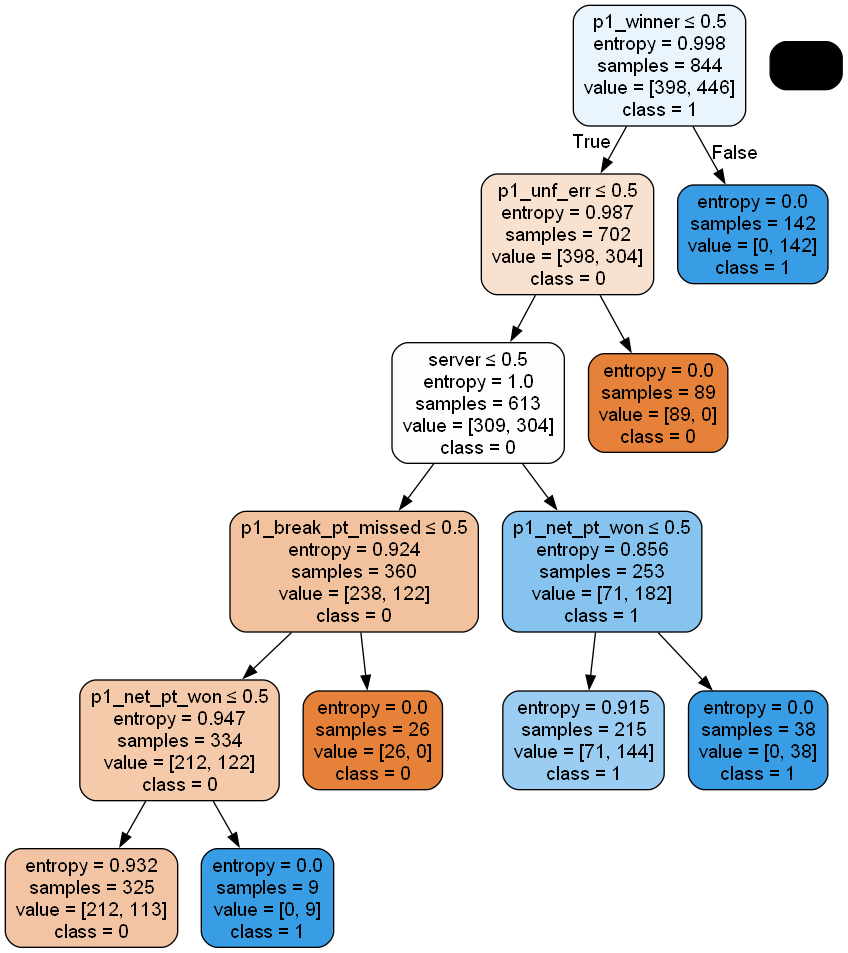

In [28]:
import graphviz
# 需安装GraphViz和pydotplus进行决策树的可视化
# 特征向量
feature_names = df.columns[1:]
# 文件缓存
dot_data = StringIO()
# 将决策树导入到dot中
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_names,class_names=['0','1'])
# 将生成的dot文件生成graph
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# 将结果存入到png文件中
graph.write_png('dttest.png')
# 显示
Image(graph.create_png())

## 决策树的特征重要性分析

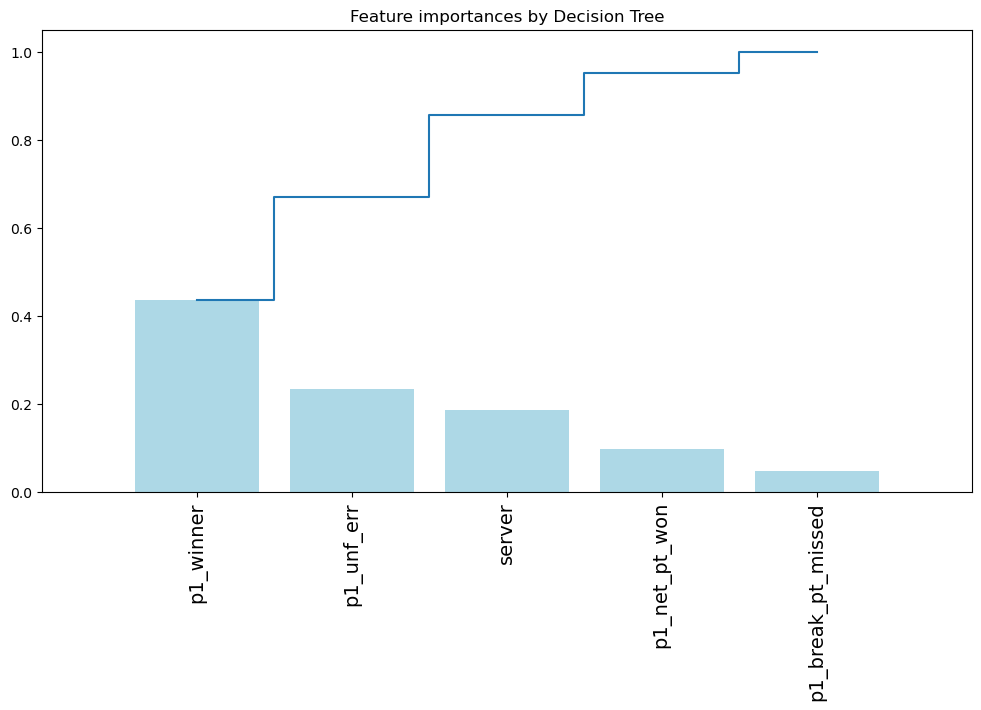

In [29]:
# 获取特征重要性
importances = dtree.feature_importances_
# 获取特征名称
feat_names = df.drop(['p1_points_won_diff'],axis=1).columns
# 排序
indices = np.argsort(importances)[::-1]
# 绘图
plt.figure(figsize=(12,6))
plt.title("Feature importances by Decision Tree")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

## 随机森林

In [30]:
# 实例化随机森林
rf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=3, 
    max_depth=None, # 定义树的深度, 可以用来防止过拟合
    min_samples_split=10, # 定义至少多少个样本的情况下才继续分叉
    #min_weight_fraction_leaf=0.02 # 定义叶子节点最少需要包含多少个样本(使用百分比表达), 防止过拟合
    )
# 模型训练
rf.fit(X_train, y_train)
# 计算指标参数
rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
print ("随机森林 AUC = %2.2f" % rf_roc_auc)
print(classification_report(y_test, rf.predict(X_test)))

随机森林 AUC = 0.77
              precision    recall  f1-score   support

           0       0.72      0.82      0.77       170
           1       0.82      0.72      0.76       193

    accuracy                           0.77       363
   macro avg       0.77      0.77      0.77       363
weighted avg       0.77      0.77      0.77       363



## 随机森林可视化

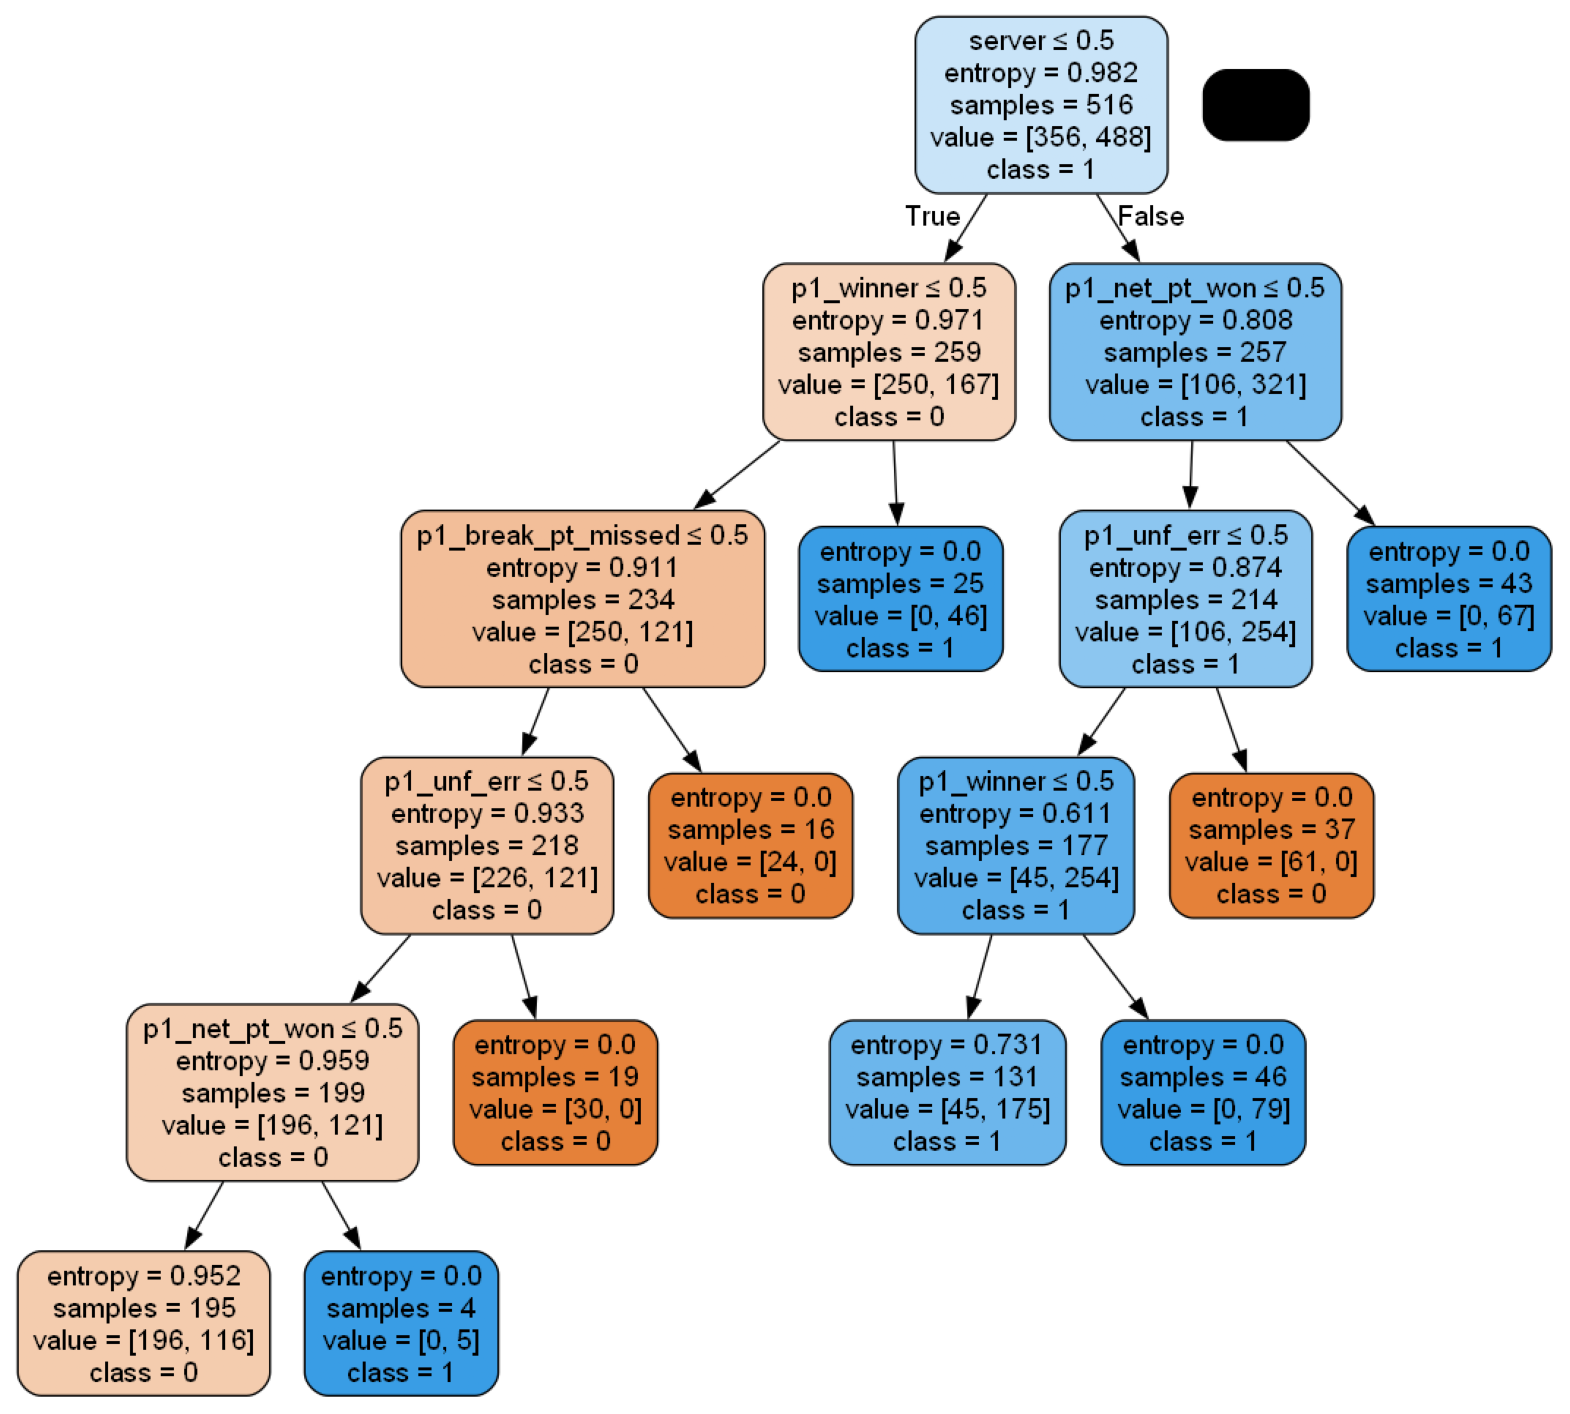

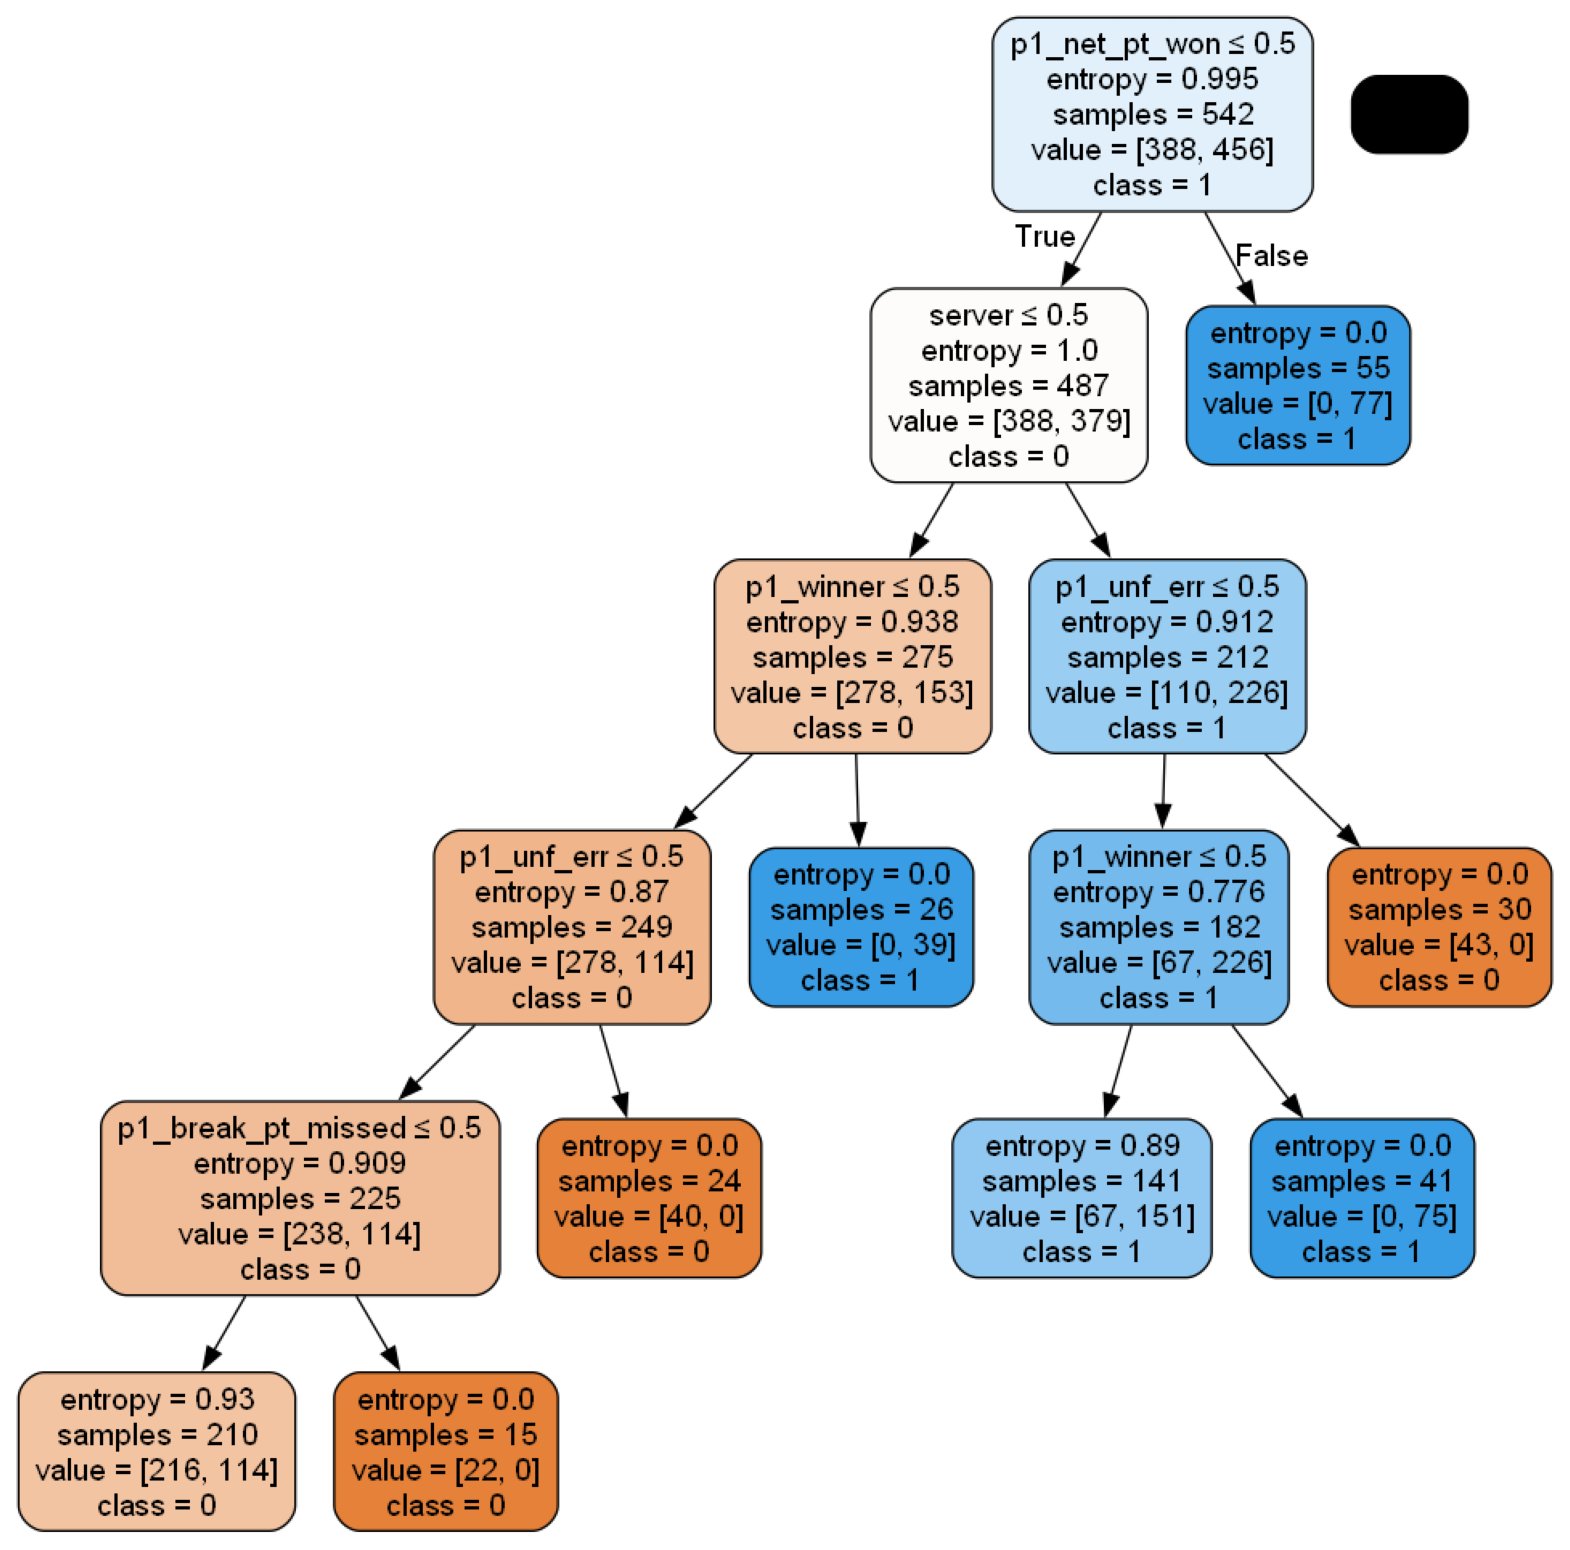

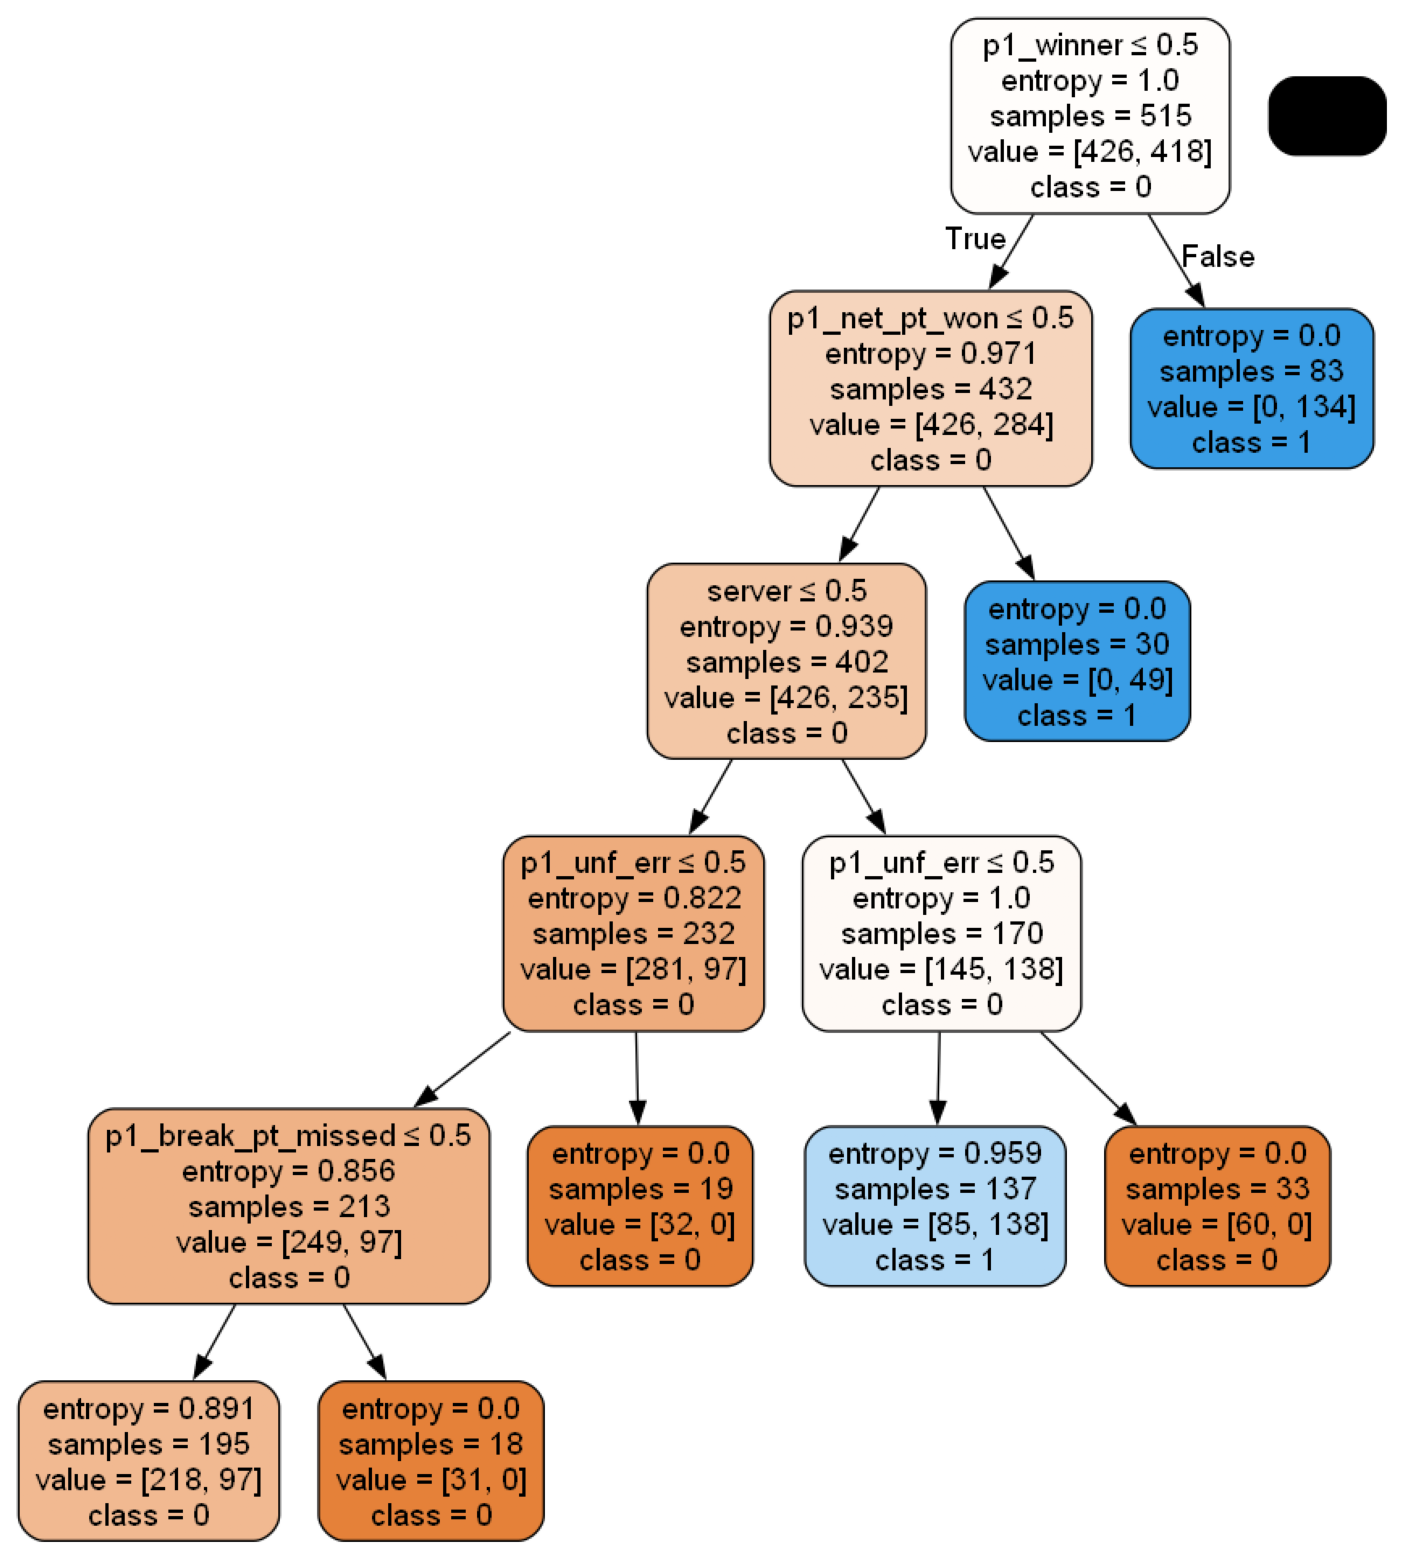

In [31]:
# Graphviz中未提供多棵树的绘制方法，所以我们遍历森林中的树，分别进行绘制
Estimators = rf.estimators_
# 遍历
for index, model in enumerate(Estimators):
    # 文件缓存
    dot_data = StringIO()
    # 将决策树导入到dot_data中
    export_graphviz(model , out_file=dot_data,
                         feature_names=df.columns[1:],
                         class_names=['0','1'],
                         filled=True, rounded=True,
                         special_characters=True)
    # 从数据中生成graph
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    # 将结果写入到png文件中
    graph.write_png('Rf{}.png'.format(index))
    # 绘制图像
    plt.figure(figsize = (20,20))
    plt.imshow(plt.imread('Rf{}.png'.format(index)))
    plt.axis('off')

## 随机森林特征分析

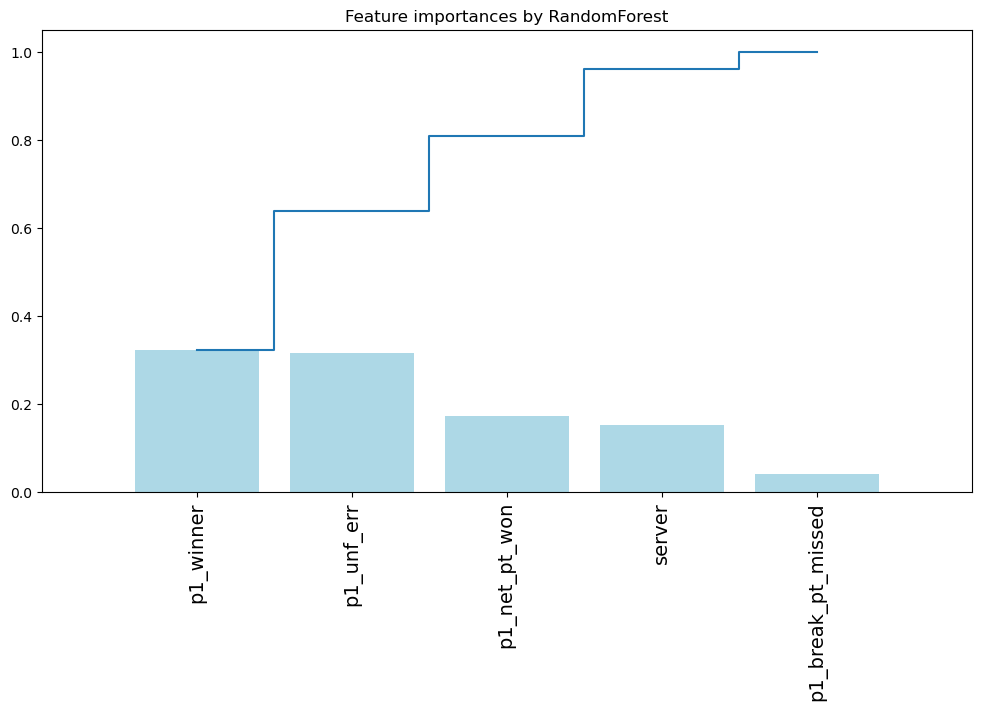

In [33]:
# 特征的重要程度
importances = rf.feature_importances_
# 特征名称
feat_names = df.drop(['p1_points_won_diff'],axis=1).columns
# 排序
indices = np.argsort(importances)[::-1]
# 绘图
plt.figure(figsize=(12,6))
plt.title("Feature importances by RandomForest")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

## ROC曲线

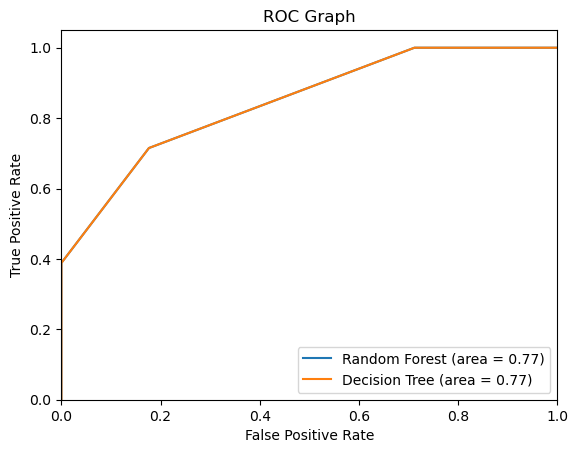

In [34]:
# ROC 图
from sklearn.metrics import roc_curve
# 计算ROC曲线
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
dt_fpr, dt_tpr, dt_thresholds = roc_curve(y_test, dtree.predict_proba(X_test)[:,1])

plt.figure()

# 随机森林 ROC
plt.plot(rf_fpr, rf_tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)

# 决策树 ROC
plt.plot(dt_fpr, dt_tpr, label='Decision Tree (area = %0.2f)' % dt_roc_auc)
# 绘图
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

In [37]:
df.to_excel('00.xlsx', index=False)
print("succeed!")

succeed!
